# 必要な関数

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import norm


def gpr_one_kernel(kernel_number,autoscaled_x, autoscaled_y,x):
    # カーネル 11 種類
    kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel(),
            ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel)
    model.fit(autoscaled_x, autoscaled_y)

    return model


def validate_model(regression_method, model,fold_number, autoscaled_x, autoscaled_y, x, y):
     # クロスバリデーションの fold 数
    fold_number = fold_number
    
    # トレーニングデータの推定(実験データ)
    autoscaled_estimated_y = model.predict(autoscaled_x)  # y の推定
    estimated_y = autoscaled_estimated_y * y.std() + y.mean()  # スケールをもとに戻す
    estimated_y = pd.DataFrame(estimated_y, index=x.index, columns=['estimated_y'])

    # トレーニングデータの実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18
    plt.scatter(y, estimated_y.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y.max(), estimated_y.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y.min(), estimated_y.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.gca().set_aspect('equal', adjustable='box')  # 図の形を正方形に
    plt.show()  # 以上の設定で描画

    # トレーニングデータのr2, RMSE, MAE
    print('r^2 for training data :', r2_score(y, estimated_y))
    print('RMSE for training data :', mean_squared_error(y, estimated_y, squared=False))
    print('MAE for training data :', mean_absolute_error(y, estimated_y))

    # トレーニングデータの結果の保存
    y_for_save = pd.DataFrame(y)
    y_for_save.columns = ['actual_y']
    y_error_train = y_for_save.iloc[:, 0] - estimated_y.iloc[:, 0]
    y_error_train = pd.DataFrame(y_error_train)
    y_error_train.columns = ['error_of_y(actual_y-estimated_y)']
    results_train = pd.concat([y_for_save, estimated_y, y_error_train], axis=1) # 結合
    results_train.to_csv('./../results/validation/estimated_y_in_detail_{0}.csv'.format(regression_method))  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    
    # クロスバリデーションによる y の値の推定
    cross_validation = KFold(n_splits=fold_number, random_state=9, shuffle=True) # クロスバリデーションの分割の設定
    autoscaled_estimated_y_in_cv = cross_val_predict(model, autoscaled_x, autoscaled_y, cv=cross_validation)  # y の推定
    estimated_y_in_cv = autoscaled_estimated_y_in_cv * y.std() + y.mean()  # スケールをもとに戻す
    estimated_y_in_cv = pd.DataFrame(estimated_y_in_cv, index=x.index, columns=['estimated_y'])

    # クロスバリデーションにおける実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18
    plt.scatter(y, estimated_y_in_cv.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y.max(), estimated_y_in_cv.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y.min(), estimated_y_in_cv.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.gca().set_aspect('equal', adjustable='box')  # 図の形を正方形に
    plt.show()  # 以上の設定で描画

    # クロスバリデーションにおけるr2, RMSE, MAE
    print('r^2 in cross-validation :', r2_score(y, estimated_y_in_cv))
    print('RMSE in cross-validation :', mean_squared_error(y, estimated_y_in_cv, squared=False))
    print('MAE in cross-validation :', mean_absolute_error(y, estimated_y_in_cv))

    # クロスバリデーションの結果の保存
    y_error_in_cv = y_for_save.iloc[:, 0] - estimated_y_in_cv.iloc[:, 0]
    y_error_in_cv = pd.DataFrame(y_error_in_cv)
    y_error_in_cv.columns = ['error_of_y(actual_y-estimated_y)']
    results_in_cv = pd.concat([y_for_save, estimated_y_in_cv, y_error_in_cv], axis=1) # 結合
    results_in_cv.to_csv('./../results/validation/estimated_y_in_cv_in_detail_{0}.csv'.format(regression_method))  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    


    

def predict(regression_method, model, autoscaled_x_prediction, x_prediction, y):
    estimated_y_prediction_std = None

    if regression_method == 'gpr_one_kernel' or regression_method == 'gpr_kernels':  # 標準偏差あり
        estimated_y_prediction, estimated_y_prediction_std = model.predict(
            autoscaled_x_prediction, return_std=True)
        estimated_y_prediction_std = estimated_y_prediction_std * y.std()
        estimated_y_prediction_std = pd.DataFrame(
            estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
        estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(
            regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    else:
        estimated_y_prediction = model.predict(autoscaled_x_prediction)

    estimated_y_prediction = estimated_y_prediction * y.std() + y.mean()
    estimated_y_prediction = pd.DataFrame(
        estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(
        regression_method))  # 予測結果を csv ファイルに保存。

    return estimated_y_prediction, estimated_y_prediction_std



def acquisition_functions(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method):
    target_range = [0, 100]  # PTR
    relaxation = 0.01  # EI, PI
    delta = 10 ** -6  # MI

    cumulative_variance = np.zeros(
        x_prediction.shape[0])  # MI で必要な "ばらつき" を 0 で初期化
    if acquisition_function == 'MI':
        acquisition_function_prediction = estimated_y_prediction + np.log(2 / delta) ** 0.5 * (
            (estimated_y_prediction_std ** 2 + cumulative_variance) ** 0.5 - cumulative_variance ** 0.5)
        cumulative_variance = cumulative_variance + estimated_y_prediction_std ** 2
    elif acquisition_function == 'EI':
        acquisition_function_prediction = (estimated_y_prediction - max(y) - relaxation * y.std()) * \
            norm.cdf((estimated_y_prediction - max(y) - relaxation * y.std()) /
                     estimated_y_prediction_std) + \
            estimated_y_prediction_std * \
            norm.pdf((estimated_y_prediction - max(y) - relaxation * y.std()) /
                     estimated_y_prediction_std)
    elif acquisition_function == 'PI':
        acquisition_function_prediction = norm.cdf(
            (estimated_y_prediction - max(y) - relaxation * y.std()) / estimated_y_prediction_std)
    elif acquisition_function == 'PTR':
        acquisition_function_prediction = norm.cdf(target_range[1],
                                                   loc=estimated_y_prediction,
                                                   scale=estimated_y_prediction_std
                                                   ) - norm.cdf(target_range[0],
                                                                loc=estimated_y_prediction,
                                                                scale=estimated_y_prediction_std)
        
    acquisition_function_prediction[estimated_y_prediction_std <= 0] = 0

    # 保存
    estimated_y_prediction = pd.DataFrame(
        estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(
        regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    estimated_y_prediction_std = pd.DataFrame(
        estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(
        regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    acquisition_function_prediction = pd.DataFrame(
        acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    acquisition_function_prediction.to_csv('acquisition_function_prediction_{0}_{1}.csv'.format(
        regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

    return estimated_y_prediction, acquisition_function_prediction, acquisition_function



# ベイズ最適化

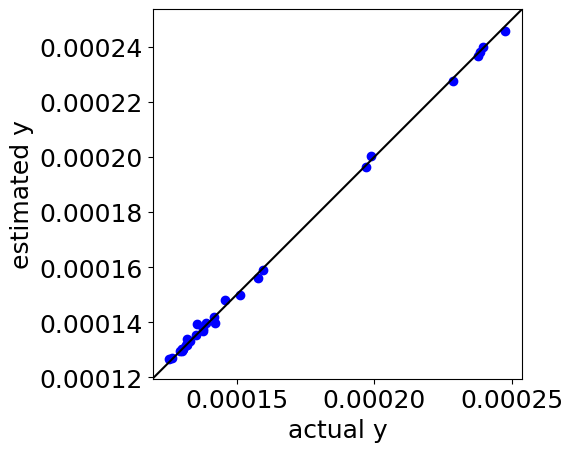

r^2 for training data : 0.9990708840209436
RMSE for training data : 1.2168050837314486e-06
MAE for training data : 8.65015328435558e-07


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.

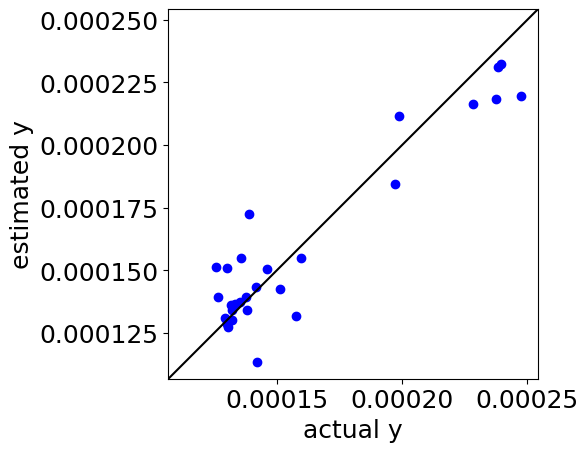

r^2 in cross-validation : 0.8708438236844168
RMSE in cross-validation : 1.4346423289758223e-05
MAE in cross-validation : 1.0417584801168698e-05
       std_of_estimated_y
id                       
59             708.663012
61            1417.326024
62             708.663012
64            3719.706026
65            3511.353460
...                   ...
59045         6914.607921
59046         6878.197397
59047         7022.706920
59048         6914.607921
59049         6878.197397

[58839 rows x 1 columns]
sample number : 1 / 30
       std_of_estimated_y
id                       
59             592.595503
61            1185.191006
62             592.595503
64            3110.478500
65            2936.250706
...                   ...
59045         5782.107276
59046         5751.660206
59047         5872.501413
59048         5782.107276
59049         5751.660206

[58838 rows x 1 columns]
sample number : 2 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             959.618752
61            1919.237503
62             959.618752
64            5036.949286
65            4754.813737
...                   ...
59045         9363.247846
59046         9313.943423
59047         9509.627473
59048         9363.247846
59049         9313.943423

[58837 rows x 1 columns]
sample number : 3 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             991.047880
61            1982.095759
62             991.047880
64            5201.917848
65            4910.541884
...                   ...
59045         9669.909963
59046         9618.990737
59047         9821.083769
59048         9669.909963
59049         9618.990737

[58836 rows x 1 columns]
sample number : 4 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1010.576532
61            2021.153063
62            1010.576532
64            5304.421920
65            5007.304378
...                   ...
59045         9860.456062
59046         9808.533469
59047        10014.608756
59048         9860.456062
59049         9808.533469

[58835 rows x 1 columns]
sample number : 5 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             955.266516
61            1910.533032
62             955.266516
64            5014.104811
65            4733.248853
...                   ...
59045         9320.781966
59046         9271.701157
59047         9466.497706
59048         9320.781966
59049         9271.701157

[58834 rows x 1 columns]
sample number : 6 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             944.295162
61            1888.590323
62             944.295162
64            4956.517196
65            4678.886904
...                   ...
59045         9213.731631
59046         9165.214521
59047         9357.773807
59048         9213.731631
59049         9165.214521

[58833 rows x 1 columns]
sample number : 7 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             943.509063
61            1887.018126
62             943.509063
64            4952.391037
65            4674.991864
...                   ...
59045         9206.061464
59046         9157.584743
59047         9349.983729
59048         9206.061464
59049         9157.584743

[58832 rows x 1 columns]
sample number : 8 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             937.829852
61            1875.659704
62             937.829852
64            4922.581390
65            4646.851950
...                   ...
59045         9150.647939
59046         9102.463011
59047         9293.703901
59048         9150.647939
59049         9102.463011

[58831 rows x 1 columns]
sample number : 9 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1275.053462
61            2550.106923
62            1275.053462
64            6692.636653
65            6317.760788
...                   ...
59045        12441.025743
59046        12375.514543
59047        12635.521577
59048        12441.025743
59049        12375.514543

[58830 rows x 1 columns]
sample number : 10 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1265.093556
61            2530.187112
62            1265.093556
64            6640.358550
65            6268.411007
...                   ...
59045        12343.845474
59046        12278.846011
59047        12536.822013
59048        12343.845474
59049        12278.846011

[58829 rows x 1 columns]
sample number : 11 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             884.877214
61            1769.754428
62             884.877214
64            4644.638650
65            4384.477750
...                   ...
59045         8633.976922
59046         8588.512666
59047         8768.955499
59048         8633.976922
59049         8588.512666

[58828 rows x 1 columns]
sample number : 12 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             873.075831
61            1746.151662
62             873.075831
64            4582.694634
65            4326.003455
...                   ...
59045         8518.828519
59046         8473.970612
59047         8652.006909
59048         8518.828519
59049         8473.970612

[58827 rows x 1 columns]
sample number : 13 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             865.745600
61            1731.491199
62             865.745600
64            4544.218924
65            4289.682890
...                   ...
59045         8447.305538
59046         8402.824252
59047         8579.365780
59048         8447.305538
59049         8402.824252

[58826 rows x 1 columns]
sample number : 14 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             844.189325
61            1688.378651
62             844.189325
64            4431.072366
65            4182.874067
...                   ...
59045         8236.976084
59046         8193.602345
59047         8365.748135
59048         8236.976084
59049         8193.602345

[58825 rows x 1 columns]
sample number : 15 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59             863.496983
61            1726.993965
62             863.496983
64            4532.416488
65            4278.541587
...                   ...
59045         8425.365945
59046         8381.000195
59047         8557.083173
59048         8425.365945
59049         8381.000195

[58824 rows x 1 columns]
sample number : 16 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1201.215196
61            2402.430392
62            1201.215196
64            6305.067941
65            5951.901200
...                   ...
59045        11720.569856
59046        11658.852422
59047        11903.802400
59048        11720.569856
59049        11658.852422

[58823 rows x 1 columns]
sample number : 17 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1195.391723
61            2390.783447
62            1195.391723
64            6274.501071
65            5923.046477
...                   ...
59045        11663.748718
59046        11602.330489
59047        11846.092954
59048        11663.748718
59049        11602.330489

[58822 rows x 1 columns]
sample number : 18 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1188.907206
61            2377.814411
62            1188.907206
64            6240.463955
65            5890.915832
...                   ...
59045        11600.476556
59046        11539.391491
59047        11781.831664
59048        11600.476556
59049        11539.391491

[58821 rows x 1 columns]
sample number : 19 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1183.165104
61            2366.330208
62            1183.165104
64            6210.324196
65            5862.464297
...                   ...
59045        11544.449382
59046        11483.659341
59047        11724.928593
59048        11544.449382
59049        11483.659341

[58820 rows x 1 columns]
sample number : 20 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1177.272408
61            2354.544815
62            1177.272408
64            6179.393503
65            5833.266075
...                   ...
59045        11486.951790
59046        11426.464506
59047        11666.532149
59048        11486.951790
59049        11426.464506

[58819 rows x 1 columns]
sample number : 21 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1172.796107
61            2345.592214
62            1172.796107
64            6155.897818
65            5811.086457
...                   ...
59045        11443.275368
59046        11383.018072
59047        11622.172915
59048        11443.275368
59049        11383.018072

[58818 rows x 1 columns]
sample number : 22 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1085.840837
61            2171.681674
62            1085.840837
64            5699.477246
65            5380.231399
...                   ...
59045        10594.829337
59046        10539.039726
59047        10760.462799
59048        10594.829337
59049        10539.039726

[58817 rows x 1 columns]
sample number : 23 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1106.123048
61            2212.246095
62            1106.123048
64            5805.936677
65            5480.727699
...                   ...
59045        10792.728101
59046        10735.896407
59047        10961.455398
59048        10792.728101
59049        10735.896407

[58816 rows x 1 columns]
sample number : 24 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1121.442814
61            2242.885627
62            1121.442814
64            5886.348249
65            5556.635111
...                   ...
59045        10942.206042
59046        10884.587226
59047        11113.270222
59048        10942.206042
59049        10884.587226

[58815 rows x 1 columns]
sample number : 25 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1137.681633
61            2275.363266
62            1137.681633
64            5971.584292
65            5637.096811
...                   ...
59045        11100.652383
59046        11042.199230
59047        11274.193622
59048        11100.652383
59049        11042.199230

[58814 rows x 1 columns]
sample number : 26 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1150.775101
61            2301.550202
62            1150.775101
64            6040.310678
65            5701.973613
...                   ...
59045        11228.408718
59046        11169.282833
59047        11403.947226
59048        11228.408718
59049        11169.282833

[58813 rows x 1 columns]
sample number : 27 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1142.127214
61            2284.254428
62            1142.127214
64            5994.918271
65            5659.123727
...                   ...
59045        11144.028074
59046        11085.346505
59047        11318.247454
59048        11144.028074
59049        11085.346505

[58812 rows x 1 columns]
sample number : 28 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1132.008905
61            2264.017810
62            1132.008905
64            5941.808219
65            5608.988539
...                   ...
59045        11045.301138
59046        10987.139440
59047        11217.977078
59048        11045.301138
59049        10987.139440

[58811 rows x 1 columns]
sample number : 29 / 30


c:\Users\Ayano\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


       std_of_estimated_y
id                       
59            1127.311313
61            2254.622626
62            1127.311313
64            5917.151001
65            5585.712450
...                   ...
59045        10999.465528
59046        10941.545189
59047        11171.424900
59048        10999.465528
59049        10941.545189

[58810 rows x 1 columns]
sample number : 30 / 30


In [39]:
# remaining_samples_number, dateを変更してから実行する

import os
import numpy as np
import pandas as pd

#次の候補の数
number_of_selecting_samples = 30

# 以下2つの変数を変更して実行する
# --------------------------------------------------
# 実験日
date = "2025-2-7"

# 残りのサンプルファイルの番号
remaining_samples_number = 7
# --------------------------------------------------


# ファイルのパスを定義
generated_samples_path = './../data/generated_samples.csv'
remaining_samples_path = f'./../data/remaining_samples/remaining_samples_{remaining_samples_number}.csv'

# 実験結果データの読み込み
dataset = pd.read_csv('./../data/result.csv', index_col=0, header=0)

if os.path.exists(remaining_samples_path):
    x_prediction = pd.read_csv(remaining_samples_path, index_col=0, header=0)
elif os.path.exists(generated_samples_path):
    x_prediction = pd.read_csv(generated_samples_path, index_col=0, header=0)


# 実験条件の全候補のインデックスのリスト
all_indexes = x_prediction.index.tolist()

# データ分割
y = dataset.iloc[:, 0]  # 目的変数
x = dataset.iloc[:, 1:]  # 説明変数

# 標準偏差が 0 の特徴量の削除
deleting_variables = x.columns[x.std() == 0]
x = x.drop(deleting_variables, axis=1)
x_prediction = x_prediction.drop(deleting_variables, axis=1)
cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化

# ガウス過程回帰(最初にカーネル関数を選択する)
regression_method = 'gpr_one_kernel'
acquisition_function = 'PTR' #PTR PI EI MI

cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化
relaxation = 0.01 #EI PI
delta = 10**-6 #MI

next_samples = pd.DataFrame([], columns=x_prediction.columns) # 次のサンプルを入れる変数を準備

for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y = (y - y.mean()) / y.std()
    autoscaled_x = (x - x.mean()) / (x.std() +1e-8)
    autoscaled_x_prediction = (x_prediction - x.mean()) / (x.std() +1e-8)

    # モデル構築
    model = gpr_one_kernel(2,autoscaled_x, autoscaled_y, x)

     # クロスバリデーション
    if sample_number == 0:
        validate = validate_model(regression_method, model,10, autoscaled_x, autoscaled_y, x, y)

    # 予測
    estimated_y_prediction, estimated_y_prediction_std = predict(regression_method, model, autoscaled_x_prediction, x_prediction, y)
    estimated_y_prediction, acquisition_function_prediction, acquisition_function = acquisition_functions(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method)


    # 保存
    estimated_y_prediction = pd.DataFrame(estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction_std = pd.DataFrame(estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    print(estimated_y_prediction_std)
    acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    if sample_number == 0:
        estimated_y_prediction.to_csv('./../data/estimated_y_prediction_gpr_one_kernel/estimated_y_prediction_{0}_{1}.csv'.format(regression_method,date))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる
        estimated_y_prediction_std.to_csv('./../data/estimated_y_prediction_gpr_one_kernel_std/estimated_y_prediction_{0}_std_{1}.csv'.format(regression_method,date))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる
        acquisition_function_prediction.to_csv('./../data/acquisiton_function_prediction/acquisition_function_prediction_{0}_{1}_{2}.csv'.format(regression_method, acquisition_function,date))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる

    # 次のサンプル
    next_samples = pd.concat([next_samples, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    
    
    # x, y, x_prediction, cumulative_variance の更新
    x = pd.concat([x, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    y = pd.concat([y, estimated_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
    x_prediction = x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
    cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
    print('sample number : {0} / {1}'.format(sample_number + 1, number_of_selecting_samples))

# 実験日の日付
x_prediction.to_csv(f'./../data/remaining_samples/remaining_samples_{remaining_samples_number+1}.csv')
next_samples.to_csv(f'./../data/next_samples/next_samples_bo_{date}.csv'.format(regression_method, acquisition_function)) # csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください